In [17]:
import gym
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
from IPython import display
import matplotlib.pyplot as plt
import os
import time
from model import DQN
from environment import PongEnvironment
from replayBuffer import ReplayBuffer

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [19]:

# Helper functions
def update_dqn(model, target_model, optimizer, batch, replay_buffer, gamma, losses):
    states, actions, rewards, next_states, dones = batch
    actions = actions.long()
    states = states.view(states.size(0), -1)
    next_states = next_states.view(next_states.size(0), -1)

    q_values = model(states).gather(1, actions.view(-1, 1)).squeeze(1)
    next_q_values = target_model(next_states).max(dim=1)[0].detach()

    target_q_values = rewards + gamma * next_q_values * (1 - dones)
    loss = F.mse_loss(q_values, target_q_values.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, q_values.mean().item()

def epsilon_greedy_policy(state, epsilon, model, action_size):
    if np.random.rand() < epsilon:
        return np.random.choice(action_size)
    else:
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).view(1, -1)
            q_values = model(state)
            return q_values.argmax().item()


In [20]:

# Defining hyperparameters
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
target_update_freq = 1000
learning_rate = 0.001
num_episodes = 10
losses = []
avg_q_values = []
episode_rewards_list = []

# Initializing environments
env = PongEnvironment()
replay_buffer = ReplayBuffer()
state_size = 6
action_size = 2
batch_size = 64
model = DQN(state_size)
target_model = DQN(state_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
if os.path.isfile("trained_model.pth"):
    checkpoint = torch.load("trained_model.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    losses = checkpoint['losses']
    avg_q_values = checkpoint['avg_q_values']
    total_num_episodes = checkpoint['total_num_episodes']
    episode_rewards_list = checkpoint['episode_rewards']
    if os.path.isfile('buffer.pkl'):
        replay_buffer.load_buffer()
    model.train()
else:
    print("TRAINING FOR FIRST TIME!")
    total_num_episodes = 0
    model.train()

In [22]:
target_model.load_state_dict(model.state_dict())
target_model.eval()

# Training Loop
epsilon = epsilon_start
total_reward = 0

for episode in range(num_episodes):
    env.reset()
    done = False
    state = env.get_striker_and_ball_coordinates()
    episode_q_values = []

    episode_reward = 0
    while not done:
        action = epsilon_greedy_policy(state, epsilon, model, action_size)
        _, reward, done, _ = env.step(action)
        episode_reward += reward
        next_state = env.get_striker_and_ball_coordinates()
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample_batch()
            loss, avg_q_value = update_dqn(model, target_model, optimizer, batch, replay_buffer, gamma, losses)
            losses.append(loss.item())
            episode_q_values.append(avg_q_value)

        if reward == 1 or reward == -1:
            done = True

        display.clear_output(wait=True)
        # env.render()
    episode_rewards_list.append(episode_reward)

    epsilon = max(epsilon_end, epsilon * 0.995)
    print(f"Episode {episode + 1} : Reward = {reward}")
    if episode % target_update_freq == 0:
        target_model.load_state_dict(model.state_dict())

    if episode_q_values:
        avg_q_values.append(np.mean(episode_q_values))

print("---------------")
print("Total reward -> ", total_reward)

Episode 10 : Reward = 1
---------------
Total reward ->  0


Total number of episodes on which model is trained:  140310


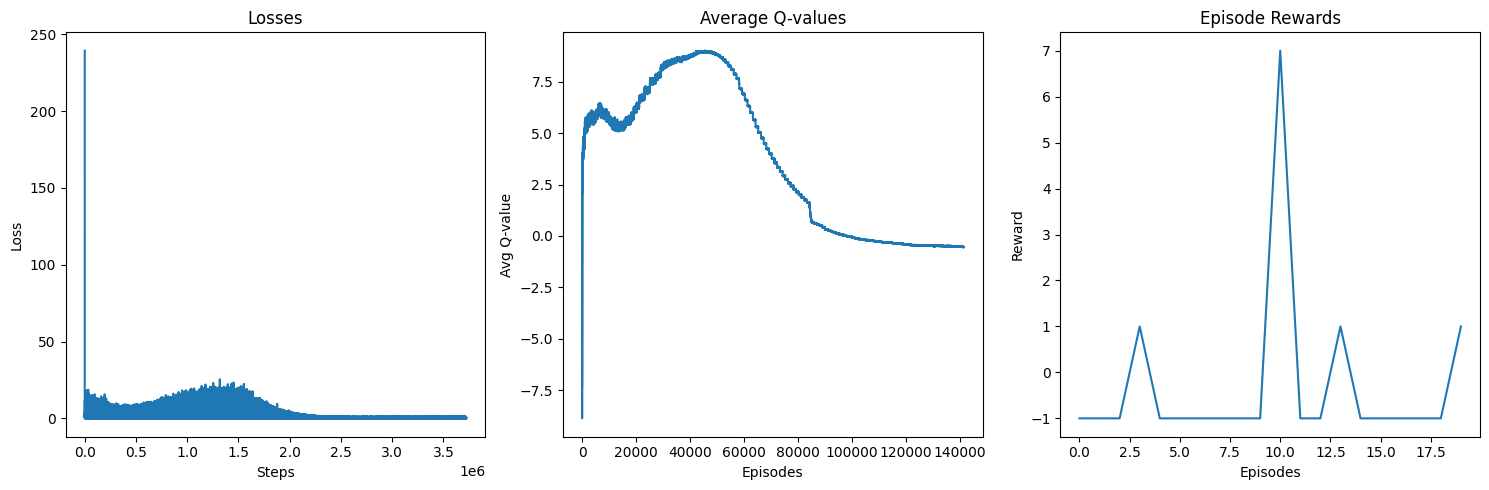

In [23]:
# Saving model and other metrics using checkpoints
PATH = "trained_model.pth"
TOTAL_NUM_EPISODES = num_episodes + total_num_episodes

replay_buffer.save_buffer()
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'losses': losses,
    'total_num_episodes': TOTAL_NUM_EPISODES,
    'avg_q_values': avg_q_values,
    'episode_rewards': episode_rewards_list
}, PATH)

print("Total number of episodes on which model is trained: ", TOTAL_NUM_EPISODES)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title('Losses')
plt.xlabel('Steps')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(avg_q_values)
plt.title('Average Q-values')
plt.xlabel('Episodes')
plt.ylabel('Avg Q-value')

plt.subplot(1, 3, 3)
plt.plot(episode_rewards_list)
plt.title('Episode Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')

plt.tight_layout()
plt.show()